In [1]:
import configparser
import random
import numpy as np
import tensorflow as tf
from sklearn.metrics import roc_auc_score, average_precision_score
from keras.models import load_model
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, Callback
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.models import load_model, Model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, \
                        Input, Dense, GlobalAveragePooling2D, Dropout
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.utils import to_categorical
from collections import Counter
import keras.optimizers
from keras.callbacks import Callback
from keras.callbacks import EarlyStopping
from keras.utils import plot_model
import glob, os
import tensorflow as tf
import pandas as pd
from random import shuffle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
from sklearn.metrics import roc_auc_score, average_precision_score, mean_squared_error, accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
import pandas as pd
from pycausal import search as s
from pycausal.pycausal import pycausal as pc
from collections import defaultdict
from numpy.polynomial.polynomial import polyfit  
from scipy.stats import pearsonr
from pylab import text
from pycausal import prior as p
import itertools

# select your GPU Here
os.environ["CUDA_VISIBLE_DEVICES"]="" #Comment this line out if you want all GPUS (2 hehe)

# python full-display web browser
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


def gen_data(mean = 0, var = 1, SIZE = 20000):
    a = np.random.normal(mean, var, SIZE)
    b = a + np.random.normal(mean, var, SIZE)
    c =  a + b + np.random.normal(mean, var, SIZE)
    return pd.DataFrame({'a' : a,'b' : b, 'c' : c})

def make_categorical(df, complete_df, categoricals):   
    retval = None
    for key in df.columns:
        if retval is not None:
            if key in categoricals:
                retval = np.concatenate((retval, to_categorical(df[key], len(complete_df[key].unique()))), axis = 1)
            else:
                retval = np.concatenate((retval, df[key].values[...,np.newaxis]), axis = 1)
        else:
            if key in categoricals:
                retval = to_categorical(df[key], len(complete_df[key].unique()))
            else:
                retval = np.expand_dims(df[key], axis = 1)
    return retval
 
num_models = 100
           
pc = pc()
pc.start_vm(java_max_heap_size = '5000M')
tetrad = s.tetradrunner()

inputs = ['Age', 'Gender', 'Total_Bilirubin', 'Direct_Bilirubin', 'Alkaline_Phosphotase', 'Alamine_Aminotransferase', 'Aspartate_Aminotransferase',
          'Total_Protiens',
          'Albumin',
         'Albumin_and_Globulin_Ratio']
target = ['Dataset']
categoricals = ['Gender'] 

/home/tkyono/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/tkyono/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
df = pd.read_csv('~/Desktop/Kaggle/indian_liver_patient.csv')
# Prior knowledge knows that the test prep comes before the outcome.
df.head()


def normalize(a):
    return (a - np.min(a)) / (np.max(a) - np.min(a))

df['Age'] = normalize(df['Age'])
df['Total_Bilirubin'] = normalize(df['Total_Bilirubin'])
df['Direct_Bilirubin'] = normalize(df['Direct_Bilirubin'])
df['Alkaline_Phosphotase'] = normalize(df['Alkaline_Phosphotase'])
df['Alamine_Aminotransferase'] = normalize(df['Alamine_Aminotransferase'])
df['Aspartate_Aminotransferase'] = normalize(df['Aspartate_Aminotransferase'])
df['Total_Protiens'] = normalize(df['Total_Protiens'])
df['Albumin'] = normalize(df['Albumin'])
df['Albumin_and_Globulin_Ratio'] = normalize(df['Albumin_and_Globulin_Ratio'])

label_encoder_list = []
for i,col in enumerate(categoricals):
    label_encoder_list.append(LabelEncoder())
    df[col] = label_encoder_list[i].fit_transform(df[col].values)
df['Dataset'] -= 1
df['Albumin_and_Globulin_Ratio'].fillna((df['Albumin_and_Globulin_Ratio'].mean()), inplace=True)
df.isnull().any()
original_df = df.copy()

[[512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [51

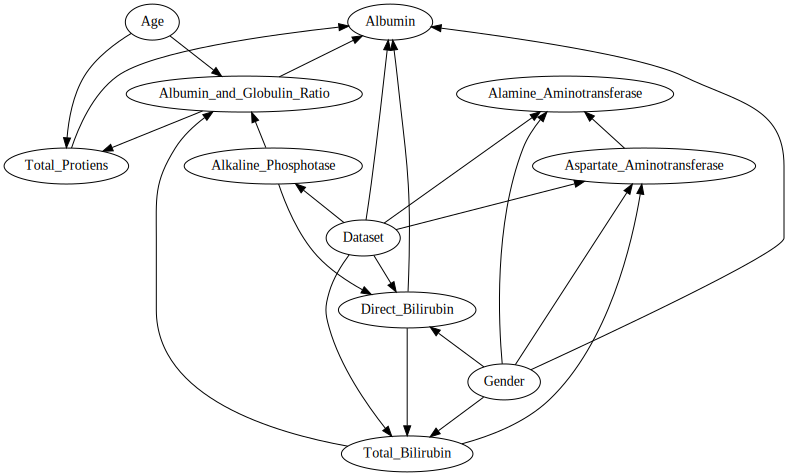

In [3]:
import pydot
from IPython.display import SVG
def examine_graph_continuous(df, prior = None):
    tetrad.run(algoId = 'fges', dfs = df,  scoreId = 'sem-bic', dataType = 'continuous',
               structurePrior = 1.0, samplePrior = 1, maxDegree = -1, maxPathLength = -1, priorKnowledge = prior,
               completeRuleSetUsed = False, faithfulnessAssumed = True, verbose = True,
               )
    return tetrad.getTetradGraph()

def examine_graph_mixed(df, prior = None):
    tetrad.run(algoId = 'fges', dfs = df, scoreId = 'cond-gauss-bic', 
           priorKnowledge = prior, dataType = 'mixed', numCategoriesToDiscretize = 2,
           structurePrior = 1.0, maxDegree = -1, faithfulnessAssumed = True, verbose = True)

    return tetrad.getTetradGraph()

def examine_graph_discrete(df, prior = None):
    tetrad.run(algoId = 'fges', dfs = df, scoreId = 'bdeu', priorKnowledge = prior, dataType = 'discrete',
               structurePrior = 1.0, samplePrior = 1.0, maxDegree = -1, faithfulnessAssumed = True, verbose = True)
    return tetrad.getTetradGraph()
    
def get_model(dense, dropouts, inputs):
    # dense is an ordered list of the number of dense neurons like [1024, 2048, 1024]
    # dropouts is an ordered list of the dropout masks like [0.2, 0.3, 0.4]
    inputs = keras.Input(shape = (inputs,))
    x = keras.layers.Dense(dense[0], activation = 'relu', kernel_initializer = 'he_normal')(inputs)
    #x = keras.layers.Dropout(dropouts[0])(x, training=True)
    for den, drop in zip(dense[1:], dropouts[1:]):
        x = keras.layers.Dense(den, activation = 'relu', kernel_initializer = 'he_normal')(x)
        #x = keras.layers.Dropout(drop)(x, training=True)
    outputs = keras.layers.Dense(2, activation = 'softmax', kernel_initializer = 'he_normal')(x)
    model = keras.Model(inputs, outputs)
    return model

def get_bic(df, prior, penalty = 2):

    tetrad.run(algoId = 'fges', dfs = df, scoreId = 'cond-gauss-bic', 
           priorKnowledge = prior, dataType = 'mixed', numCategoriesToDiscretize = 9,
           structurePrior = 1.0, maxDegree = -1, faithfulnessAssumed = True, verbose = True,
              penalty = 200)
    
    BIC = tetrad.getTetradGraph().getAllAttributes().toString()
    BIC = float(BIC.split('=')[-1].split('}')[0])
    return BIC #/ len(df)

tempForbid = p.ForbiddenWithin(['Age', 'Gender'])
temporal = [['Age', 'Gender'], target, ['Total_Bilirubin', 'Direct_Bilirubin', 'Alkaline_Phosphotase', 'Alamine_Aminotransferase', 'Aspartate_Aminotransferase',
          'Total_Protiens', 'Albumin','Albumin_and_Globulin_Ratio']]

prior = p.knowledge( addtemporal = temporal)
#prior = None

g = examine_graph_mixed(df, prior = prior)
dot_str = pc.tetradGraphToDot(g)
graphs = pydot.graph_from_dot_data(dot_str)
svg_str = graphs[0].create_svg()

known_conx = set({})
for i in tetrad.getEdges():
    if ' --> ' in i:
        known_conx.add((i.split(' --> ')[0], i.split(' --> ')[1]))
known_conx

prior = p.knowledge(requiredirect =  list(map(list, known_conx)),)
models = []
model_names = []



randomize = False
if randomize:
    layers = [256, 512, 1024, 2048, 4096]
    for i in range(num_models):
        network = []
        for j in range(3):
            network.append(layers[random.randint(0,len(layers) -1)])
        models.append(network)
        model_names.append('temp/liver' + str(i))
    print(models, model_names)    
else:
    model_layers = [512,256]
    for i in range(num_models):
        models.append(model_layers)
        model_names.append('temp/liver' + str(i))

print(models, model_names)
SVG(svg_str)



# Note that I had to update CAUSAL_SPLIT to be 0.4 for more identifiable estimates.

In [4]:
verbosity = 0
bestBIC = []
bestAUC = []
bestCOMBO = []


for t in range(10):

    df = original_df.copy()
    df_test = df[df['Alamine_Aminotransferase'] < 0.008].copy()
    df.drop(df_test.index, inplace = True)
    


    df_test.reset_index(inplace = True)
    df.sample(frac= 1).reset_index(inplace = True) # this will shuffle and reset index

    x_test = df_test[inputs]
    y_test = df_test[target]

    causal_split = 0.2
    val_split = 0.2
    train_split = 1 - (causal_split + val_split)

    x_causal = df[inputs][-int(causal_split * len(df)) :]
    y_causal = df[target][-int(causal_split * len(df)) :]

    x_val = df[inputs][int(train_split * len(df)):-int(causal_split * len(df))]
    y_val = df[target][int(train_split * len(df)):-int(causal_split * len(df))]

    x_train = df[inputs][:int(train_split * len(df))]
    y_train = df[target][:int(train_split * len(df))]
    len(x_causal), len(y_causal), len(x_val), len(y_val), len(x_train), len(y_train)
    print(len(x_train), len(x_val), len(x_causal), len(x_test))


    x_test_NN = make_categorical(x_test, original_df, categoricals)
    x_causal_NN = make_categorical(x_causal, original_df, categoricals)
    x_val_NN = make_categorical(x_val, original_df, categoricals)
    x_train_NN = make_categorical(x_train, original_df, categoricals)

    y_test_NN = make_categorical(y_test, original_df, target)
    y_causal_NN = make_categorical(y_causal, original_df, target)
    y_val_NN = make_categorical(y_val, original_df, target)
    y_train_NN = make_categorical(y_train, original_df, target)

    verbosity = 0


    for idx, model_name in enumerate(model_names):
        print(model_name)

        if type(models[idx]) is list:
            #clear session
            keras.backend.clear_session() 
            #get model according to specification
            model = get_model(models[idx], [0.2] * len(models), np.shape(x_train_NN)[1])
            callbacks = [ModelCheckpoint(model_name, verbose= verbosity, monitor='val_loss',save_best_only=True), 
                         EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=2, verbose= verbosity, mode='auto')]
            model.compile(optimizer = optimizers.SGD(lr = 0.0001, momentum = 0.9, ), loss='binary_crossentropy', metrics = ['accuracy'])
            #print(len(X), len(y))
            model.fit(x_train_NN, y_train_NN, epochs = 20, validation_data = (x_val_NN, y_val_NN), callbacks = callbacks, batch_size = 8, verbose = verbosity)
        else:
            models[idx].fit(X,y)





    violation = []
    generalization = []
    metrics = []
    proposed = []
    x_causal.reset_index(drop = True, inplace = True)

    for idx, model_name in enumerate(model_names):
        print(model_name)
        if type(models[idx]) is list:
            keras.backend.clear_session()
            model = load_model(model_name)
        else:
            model = models[idx]

        y_pred = model.predict(x_test_NN)
        generalization.append(roc_auc_score(y_test,y_pred[:,1]))

        
        
        #### CHECK FOR CAUSAL METRIC HERE
        y_causal_pred = model.predict(x_causal_NN)[:,1]
        print("AUC = ", roc_auc_score(y_causal, y_causal_pred))
        metrics.append(roc_auc_score(y_causal, y_causal_pred))
        y_causal_pred[y_causal_pred > 0.5] = 1
        y_causal_pred[y_causal_pred <= 0.5] = 0
        causal_targets = pd.DataFrame(y_causal_pred, columns = target)
        causal_targets.reset_index(drop=True, inplace = True)
        causal_df = x_causal.join(causal_targets)



        #print(x_causal.head)
        bic_pred = get_bic(causal_df, prior)
        #print(bic_pred, tetrad.getEdges())
        print(bic_pred)
        found_conx = set({})
        for i in tetrad.getEdges():
            if ' --> ' in i:
                found_conx.add((i.split(' --> ')[0], i.split(' --> ')[1]))
        found_conx

        if found_conx == known_conx:
            proposed.append(bic_pred)
            violation.append(0)
        else:
            print("******Found an error")
            # for now just remove bad model.  Will need to add it to distance metric.
            proposed.append(bic_pred)
            violation.append(1)
            #metrics = metrics[:-1]
            #generalization = generalization[:-1]


    nbest = 10
    print(proposed)
    total = normalize(metrics) - (normalize(proposed) + np.array(violation))
    #total = normalize(metrics) - normalize(proposed)
    final = pd.DataFrame(np.stack((metrics, proposed, total, generalization), axis = 1), columns = ['metrics', 'proposed', 'combined', 'generalization'])
    print("AUC = ", np.mean(final.nlargest(nbest, 'metrics')['generalization']))
    print("BIC = ", np.mean(final.nlargest(nbest, 'proposed')['generalization']))
    print("COMB = ",np.mean(final.nlargest(nbest, 'combined')['generalization']))
    bestAUC.append(np.mean(final.nlargest(nbest, 'metrics')['generalization']))
    bestBIC.append(np.mean(final.nlargest(nbest, 'proposed')['generalization']))
    bestCOMBO.append(np.mean(final.nlargest(nbest, 'combined')['generalization']))
    
np.mean(bestAUC), np.mean(bestBIC), np.mean(bestCOMBO)

238 80 79 186
temp/liver0
temp/liver1
temp/liver2
temp/liver3
temp/liver4
temp/liver5
temp/liver6
temp/liver7
temp/liver8
temp/liver9
temp/liver10
temp/liver11
temp/liver12
temp/liver13
temp/liver14
temp/liver15
temp/liver16
temp/liver17
temp/liver18
temp/liver19
temp/liver20
temp/liver21
temp/liver22
temp/liver23
temp/liver24
temp/liver25
temp/liver26
temp/liver27
temp/liver28
temp/liver29
temp/liver30
temp/liver31
temp/liver32
temp/liver33
temp/liver34
temp/liver35
temp/liver36
temp/liver37
temp/liver38
temp/liver39
temp/liver40
temp/liver41
temp/liver42
temp/liver43
temp/liver44
temp/liver45
temp/liver46
temp/liver47
temp/liver48
temp/liver49
temp/liver50
temp/liver51
temp/liver52
temp/liver53
temp/liver54
temp/liver55
temp/liver56
temp/liver57
temp/liver58
temp/liver59
temp/liver60
temp/liver61
temp/liver62
temp/liver63
temp/liver64
temp/liver65
temp/liver66
temp/liver67
temp/liver68
temp/liver69
temp/liver70
temp/liver71
temp/liver72
temp/liver73
temp/liver74
temp/liver75
temp/liv

AUC =  0.6593406593406592
945.4418456922763
******Found an error
temp/liver90
AUC =  0.7703296703296704
945.4418456922763
******Found an error
temp/liver91
AUC =  0.8032967032967033
945.4418456922763
******Found an error
temp/liver92
AUC =  0.7703296703296703
945.4418456922763
******Found an error
temp/liver93
AUC =  0.7384615384615384
945.4418456922763
******Found an error
temp/liver94
AUC =  0.8219780219780219
945.4418456922763
******Found an error
temp/liver95
AUC =  0.8428571428571429
945.4418456922763
******Found an error
temp/liver96
AUC =  0.7703296703296703
945.4418456922763
******Found an error
temp/liver97
AUC =  0.789010989010989
945.4418456922763
******Found an error
temp/liver98
AUC =  0.7835164835164835
945.4418456922763
******Found an error
temp/liver99
AUC =  0.7967032967032968
945.4418456922763
******Found an error
[945.4418456922763, 945.4418456922763, 945.4418456922763, 945.4418456922763, 945.4418456922763, 945.4418456922763, 945.4418456922763, 945.4418456922763, 945

/home/tkyono/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


temp/liver1
temp/liver2
temp/liver3
temp/liver4
temp/liver5
temp/liver6
temp/liver7
temp/liver8
temp/liver9
temp/liver10
temp/liver11
temp/liver12
temp/liver13
temp/liver14
temp/liver15
temp/liver16
temp/liver17
temp/liver18
temp/liver19
temp/liver20
temp/liver21
temp/liver22
temp/liver23
temp/liver24
temp/liver25
temp/liver26
temp/liver27
temp/liver28
temp/liver29
temp/liver30
temp/liver31
temp/liver32
temp/liver33
temp/liver34
temp/liver35
temp/liver36
temp/liver37
temp/liver38
temp/liver39
temp/liver40
temp/liver41
temp/liver42
temp/liver43
temp/liver44
temp/liver45
temp/liver46
temp/liver47
temp/liver48
temp/liver49
temp/liver50
temp/liver51
temp/liver52
temp/liver53
temp/liver54
temp/liver55
temp/liver56
temp/liver57
temp/liver58
temp/liver59
temp/liver60
temp/liver61
temp/liver62
temp/liver63
temp/liver64
temp/liver65
temp/liver66
temp/liver67
temp/liver68
temp/liver69
temp/liver70
temp/liver71
temp/liver72
temp/liver73
temp/liver74
temp/liver75
temp/liver76
temp/liver77
temp/liv

AUC =  0.7714285714285715
945.4418456922763
******Found an error
temp/liver90
AUC =  0.778021978021978
945.4418456922763
******Found an error
temp/liver91
AUC =  0.7802197802197802
945.4418456922763
******Found an error
temp/liver92
AUC =  0.8395604395604396
945.4418456922763
******Found an error
temp/liver93
AUC =  0.7681318681318682
945.4418456922763
******Found an error
temp/liver94
AUC =  0.8263736263736263
945.4418456922763
******Found an error
temp/liver95
AUC =  0.8054945054945055
945.4418456922763
******Found an error
temp/liver96
AUC =  0.7626373626373626
945.4418456922763
******Found an error
temp/liver97
AUC =  0.834065934065934
945.4418456922763
******Found an error
temp/liver98
AUC =  0.7516483516483516
945.4418456922763
******Found an error
temp/liver99
AUC =  0.7901098901098901
945.4418456922763
******Found an error
[945.4418456922763, 945.4418456922763, 945.4418456922763, 945.4418456922763, 945.4418456922763, 945.4418456922763, 945.4418456922763, 945.4418456922763, 945.

AUC =  0.8208791208791208
945.4418456922763
******Found an error
temp/liver54
AUC =  0.8483516483516483
945.4418456922763
******Found an error
temp/liver55
AUC =  0.8263736263736263
945.4418456922763
******Found an error
temp/liver56
AUC =  0.7197802197802198
945.4418456922763
******Found an error
temp/liver57
AUC =  0.7571428571428571
945.4418456922763
******Found an error
temp/liver58
AUC =  0.8065934065934066
945.4418456922763
******Found an error
temp/liver59
AUC =  0.7450549450549451
945.4418456922763
******Found an error
temp/liver60
AUC =  0.7604395604395604
945.4418456922763
******Found an error
temp/liver61
AUC =  0.8021978021978022
945.4418456922763
******Found an error
temp/liver62
AUC =  0.8384615384615385
945.4418456922763
******Found an error
temp/liver63
AUC =  0.756043956043956
945.4418456922763
******Found an error
temp/liver64
AUC =  0.7692307692307693
945.4418456922763
******Found an error
temp/liver65
AUC =  0.7923076923076924
945.4418456922763
******Found an error


AUC =  0.7472527472527473
945.4418456922763
******Found an error
temp/liver18
AUC =  0.7813186813186813
945.4418456922763
******Found an error
temp/liver19
AUC =  0.7758241758241758
945.4418456922763
******Found an error
temp/liver20
AUC =  0.7142857142857143
945.4418456922763
******Found an error
temp/liver21
AUC =  0.7395604395604396
945.4418456922763
******Found an error
temp/liver22
AUC =  0.8098901098901099
945.4418456922763
******Found an error
temp/liver23
AUC =  0.8153846153846154
945.4418456922763
******Found an error
temp/liver24
AUC =  0.8120879120879121
945.4418456922763
******Found an error
temp/liver25
AUC =  0.7769230769230769
945.4418456922763
******Found an error
temp/liver26
AUC =  0.7131868131868132
945.4418456922763
******Found an error
temp/liver27
AUC =  0.798901098901099
945.4418456922763
******Found an error
temp/liver28
AUC =  0.7472527472527473
945.4418456922763
******Found an error
temp/liver29
AUC =  0.8197802197802198
945.4418456922763
******Found an error


temp/liver1
temp/liver2
temp/liver3
temp/liver4
temp/liver5
temp/liver6
temp/liver7
temp/liver8
temp/liver9
temp/liver10
temp/liver11
temp/liver12
temp/liver13
temp/liver14
temp/liver15
temp/liver16
temp/liver17
temp/liver18
temp/liver19
temp/liver20
temp/liver21
temp/liver22
temp/liver23
temp/liver24
temp/liver25
temp/liver26
temp/liver27
temp/liver28
temp/liver29
temp/liver30
temp/liver31
temp/liver32
temp/liver33
temp/liver34
temp/liver35
temp/liver36
temp/liver37
temp/liver38
temp/liver39
temp/liver40
temp/liver41
temp/liver42
temp/liver43
temp/liver44
temp/liver45
temp/liver46
temp/liver47
temp/liver48
temp/liver49
temp/liver50
temp/liver51
temp/liver52
temp/liver53
temp/liver54
temp/liver55
temp/liver56
temp/liver57
temp/liver58
temp/liver59
temp/liver60
temp/liver61
temp/liver62
temp/liver63
temp/liver64
temp/liver65
temp/liver66
temp/liver67
temp/liver68
temp/liver69
temp/liver70
temp/liver71
temp/liver72
temp/liver73
temp/liver74
temp/liver75
temp/liver76
temp/liver77
temp/liv

945.4418456922763
******Found an error
temp/liver90
AUC =  0.8010989010989011
945.4418456922763
******Found an error
temp/liver91
AUC =  0.7769230769230769
945.4418456922763
******Found an error
temp/liver92
AUC =  0.7824175824175824
945.4418456922763
******Found an error
temp/liver93
AUC =  0.8065934065934066
945.4418456922763
******Found an error
temp/liver94
AUC =  0.7747252747252746
945.4418456922763
******Found an error
temp/liver95
AUC =  0.7615384615384615
945.4418456922763
******Found an error
temp/liver96
AUC =  0.8087912087912088
945.4418456922763
******Found an error
temp/liver97
AUC =  0.8
945.4418456922763
******Found an error
temp/liver98
AUC =  0.8241758241758241
945.4418456922763
******Found an error
temp/liver99
AUC =  0.7912087912087912
945.4418456922763
******Found an error
[945.4418456922763, 945.4418456922763, 945.4418456922763, 945.4418456922763, 945.4418456922763, 945.4418456922763, 945.4418456922763, 945.4418456922763, 945.4418456922763, 945.4418456922763, 945.4

945.4418456922763
******Found an error
temp/liver54
AUC =  0.8175824175824176
945.4418456922763
******Found an error
temp/liver55
AUC =  0.7395604395604396
945.4418456922763
******Found an error
temp/liver56
AUC =  0.8164835164835165
945.4418456922763
******Found an error
temp/liver57
AUC =  0.7703296703296704
945.4418456922763
******Found an error
temp/liver58
AUC =  0.8351648351648352
945.4418456922763
******Found an error
temp/liver59
AUC =  0.810989010989011
945.4418456922763
******Found an error
temp/liver60
AUC =  0.8153846153846154
945.4418456922763
******Found an error
temp/liver61
AUC =  0.810989010989011
945.4418456922763
******Found an error
temp/liver62
AUC =  0.8362637362637362
945.4418456922763
******Found an error
temp/liver63
AUC =  0.7945054945054945
945.4418456922763
******Found an error
temp/liver64
AUC =  0.8087912087912088
945.4418456922763
******Found an error
temp/liver65
AUC =  0.7472527472527473
945.4418456922763
******Found an error
temp/liver66
AUC =  0.82747

945.4418456922763
******Found an error
temp/liver18
AUC =  0.7769230769230769
945.4418456922763
******Found an error
temp/liver19
AUC =  0.7604395604395604
945.4418456922763
******Found an error
temp/liver20
AUC =  0.7494505494505495
945.4418456922763
******Found an error
temp/liver21
AUC =  0.8351648351648352
945.4418456922763
******Found an error
temp/liver22
AUC =  0.7802197802197802
945.4418456922763
******Found an error
temp/liver23
AUC =  0.7912087912087912
945.4418456922763
******Found an error
temp/liver24
AUC =  0.754945054945055
945.4418456922763
******Found an error
temp/liver25
AUC =  0.7978021978021979
945.4418456922763
******Found an error
temp/liver26
AUC =  0.8274725274725274
945.4418456922763
******Found an error
temp/liver27
AUC =  0.7846153846153846
945.4418456922763
******Found an error
temp/liver28
AUC =  0.8329670329670329
945.4418456922763
******Found an error
temp/liver29
AUC =  0.8406593406593407
945.4418456922763
******Found an error
temp/liver30
AUC =  0.8142

temp/liver1
temp/liver2
temp/liver3
temp/liver4
temp/liver5
temp/liver6
temp/liver7
temp/liver8
temp/liver9
temp/liver10
temp/liver11
temp/liver12
temp/liver13
temp/liver14
temp/liver15
temp/liver16
temp/liver17
temp/liver18
temp/liver19
temp/liver20
temp/liver21
temp/liver22
temp/liver23
temp/liver24
temp/liver25
temp/liver26
temp/liver27
temp/liver28
temp/liver29
temp/liver30
temp/liver31
temp/liver32
temp/liver33
temp/liver34
temp/liver35
temp/liver36
temp/liver37
temp/liver38
temp/liver39
temp/liver40
temp/liver41
temp/liver42
temp/liver43
temp/liver44
temp/liver45
temp/liver46
temp/liver47
temp/liver48
temp/liver49
temp/liver50
temp/liver51
temp/liver52
temp/liver53
temp/liver54
temp/liver55
temp/liver56
temp/liver57
temp/liver58
temp/liver59
temp/liver60
temp/liver61
temp/liver62
temp/liver63
temp/liver64
temp/liver65
temp/liver66
temp/liver67
temp/liver68
temp/liver69
temp/liver70
temp/liver71
temp/liver72
temp/liver73
temp/liver74
temp/liver75
temp/liver76
temp/liver77
temp/liv

AUC =  0.8021978021978022
945.4418456922763
******Found an error
temp/liver90
AUC =  0.7923076923076923
945.4418456922763
******Found an error
temp/liver91
AUC =  0.8087912087912087
945.4418456922763
******Found an error
temp/liver92
AUC =  0.7472527472527473
945.4418456922763
******Found an error
temp/liver93
AUC =  0.8043956043956044
945.4418456922763
******Found an error
temp/liver94
AUC =  0.7934065934065935
945.4418456922763
******Found an error
temp/liver95
AUC =  0.7461538461538462
945.4418456922763
******Found an error
temp/liver96
AUC =  0.7648351648351648
945.4418456922763
******Found an error
temp/liver97
AUC =  0.7725274725274726
945.4418456922763
******Found an error
temp/liver98
AUC =  0.7318681318681319
945.4418456922763
******Found an error
temp/liver99
AUC =  0.7681318681318681
945.4418456922763
******Found an error
[945.4418456922763, 945.4418456922763, 945.4418456922763, 945.4418456922763, 945.4418456922763, 945.4418456922763, 945.4418456922763, 945.4418456922763, 94

945.4418456922763
******Found an error
temp/liver53
AUC =  0.7593406593406593
945.4418456922763
******Found an error
temp/liver54
AUC =  0.856043956043956
945.4418456922763
******Found an error
temp/liver55
AUC =  0.8098901098901099
945.4418456922763
******Found an error
temp/liver56
AUC =  0.8153846153846154
945.4418456922763
******Found an error
temp/liver57
AUC =  0.7197802197802198
945.4418456922763
******Found an error
temp/liver58
AUC =  0.7999999999999999
945.4418456922763
******Found an error
temp/liver59
AUC =  0.7417582417582418
945.4418456922763
******Found an error
temp/liver60
AUC =  0.8329670329670329
945.4418456922763
******Found an error
temp/liver61
AUC =  0.7769230769230768
945.4418456922763
******Found an error
temp/liver62
AUC =  0.8186813186813187
945.4418456922763
******Found an error
temp/liver63
AUC =  0.832967032967033
945.4418456922763
******Found an error
temp/liver64
AUC =  0.7846153846153846
945.4418456922763
******Found an error
temp/liver65
AUC =  0.76703

945.4418456922763
******Found an error
temp/liver17
AUC =  0.8021978021978022
945.4418456922763
******Found an error
temp/liver18
AUC =  0.7604395604395604
945.4418456922763
******Found an error
temp/liver19
AUC =  0.8010989010989011
945.4418456922763
******Found an error
temp/liver20
AUC =  0.767032967032967
945.4418456922763
******Found an error
temp/liver21
AUC =  0.779120879120879
945.4418456922763
******Found an error
temp/liver22
AUC =  0.832967032967033
945.4418456922763
******Found an error
temp/liver23
AUC =  0.8131868131868132
945.4418456922763
******Found an error
temp/liver24
AUC =  0.8373626373626374
945.4418456922763
******Found an error
temp/liver25
AUC =  0.8219780219780219
945.4418456922763
******Found an error
temp/liver26
AUC =  0.778021978021978
945.4418456922763
******Found an error
temp/liver27
AUC =  0.7340659340659341
945.4418456922763
******Found an error
temp/liver28
AUC =  0.7835164835164834
945.4418456922763
******Found an error
temp/liver29
AUC =  0.8043956

(0.583991916023166, 0.5805646718146718, nan)

In [5]:
df = original_df.copy()
len(df[df['Alamine_Aminotransferase'] < 0.008]), len(df)
y_test[target]

,Dataset
0,0
1,0
2,0
3,0
4,0
5,1
6,0
7,1
8,0
9,0


/home/tkyono/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RankWarning: The fit may be poorly conditioned
  


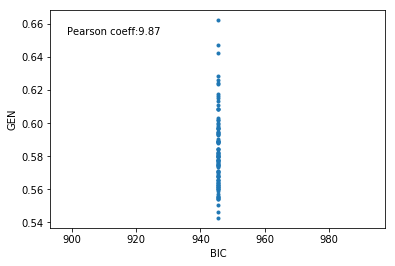

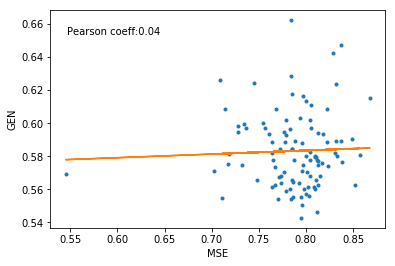

/home/tkyono/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


ValueError: On entry to DLASCL parameter number 4 had an illegal value

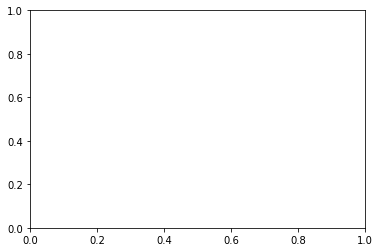

In [6]:
fig, ax = plt.subplots()
b,m = polyfit(proposed,generalization, 1)
text(0.05, 0.9,'Pearson coeff:' + str(pearsonr(proposed,generalization)[0])[0:4], ha='left', va='center', transform=ax.transAxes)
ax.plot(proposed,generalization, '.')
plt.plot(proposed, b + m * np.array(proposed), '-')
ax.set_xlabel("BIC")
ax.set_ylabel("GEN")
fig.savefig('Ex4MSEVsAUS.pdf', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots()
b,m = polyfit(metrics,generalization, 1)
text(0.05, 0.9,'Pearson coeff:' + str(pearsonr(metrics,generalization)[0])[0:4], ha='left', va='center', transform=ax.transAxes)
ax.plot(metrics,generalization, '.')
plt.plot(metrics, b + m * np.array(metrics), '-')
ax.set_xlabel("MSE")
ax.set_ylabel("GEN")
fig.savefig('Ex4MSEVsAUS.pdf', bbox_inches='tight')
plt.show()


total = normalize(metrics) - (normalize(proposed) + np.array(violation))
fig, ax = plt.subplots()
b,m = polyfit(total,generalization, 1)
text(0.05, 0.9,'Pearson coeff:' + str(pearsonr(total,generalization)[0])[0:4], ha='left', va='center', transform=ax.transAxes)
ax.plot(total,generalization, '.')
plt.plot(total, b + m * np.array(total), '-')
ax.set_xlabel("MSE")
ax.set_ylabel("GEN")
fig.savefig('Ex4MSEVsAUS.pdf', bbox_inches='tight')
plt.show()


## 